In [0]:
#hosted at https://colab.research.google.com/drive/1nlqBIZryO4KiintHYfUVZZ_xVK6p_2mn

In [0]:
import numpy as np
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
#hosted on colab

In [0]:
x=np.array([12,123,32,5,4,3,5,67])
y=np.array([11,133,22,5,2,1,5,44])
pearsonr(x,y) #returns (corr,p-value of the 2 tailed test)

(0.9771274513188724, 2.9403813332491067e-05)

In [0]:
#function that returns rolling correlations
def roll_corr(x,y,length=5):
  corr=[]
  x_len=len(x)
  if (x_len!=len(y)):
    raise ValueError('Length of datasets do not match')
    return
  if (length>x_len):
    raise ValueError('Length of rolling window exceeds data')
    return
  for i in range(x_len):
    if (i+length>=x_len):
      break
    temp=pearsonr(x[i:i+length],y[i:i+length])[0]
    corr.append(temp)
  return corr

In [0]:
#example of above function
roll_corr(x,y,4)

[0.9953771854549682,
 0.9956629841931625,
 0.9929078162734514,
 0.9710607611177228]

In [0]:
'''
Class for creating a data environment. Input a list of urls, list of date type and list of date formats
List of url refers to a list of the urls of the raw data
List of data type should be comprised of 0 and 1s and should correspond to each url. 0 refers to equities data, 1 refers to other data
Equity data should have Date, High and Low columns
Other data should have Date and Value columns
List of date formats refers to the formats of the data in the Date column. 
If not necessary, please enter a ''. Otherwise enter the date format. This is the same as strptime format codes

Upon execution, the data is imported, cleaned and stored in the class.
'''
class data_environment(object):
  def __init__(self,main,url_list,data_type,date_format):
    for i in range(len(url_list)):
      url_list[i] = main+url_list[i]
    self.check_inputs(url_list,data_type,date_format)
    self.init_data(url_list) 
    self.preprocess_data()

  def check_inputs(self,url_list,data_type,date_format): 
    if (len(url_list)!=len(data_type) or len(url_list)!=len(date_format)):
      raise ValueError('Diff lengths of url and data type obtained')
    temp=data_type.copy()
    temp=list(dict.fromkeys(temp))
    temp.sort()
    if (any(i!=0 and i!=1 for i in temp)):
      raise ValueError('Invalid data type input')  
    self.data_type=data_type
    self.date_format=date_format
            
  def init_data(self,url_list): 
    self.raw_data=[]
    for i in range(len(url_list)):
      temp=pd.read_csv(url_list[i]).dropna()
      temp=temp.reset_index()
      self.raw_data.append(temp)  

  def get_daily_price(self,data): 
    return data.loc[:,['High','Low']].mean(axis=1).values

  def get_logr(self,data):
    returns=data[1:]/data[:-1]
    return pd.Series(np.log(returns)).rename('Log-return')

  def get_datetime(self,data,i):
    if self.date_format[i]=='':
      date=pd.to_datetime(data.Date)
    else:
      date=pd.to_datetime(data.Date,format=self.date_format[i],exact=False)
    return date     

  def preprocess_data(self): 
    self.data=[]
    for i in range(len(self.raw_data)):
      if (self.data_type[i]==0):
        
        self.raw_data[i].Date=self.get_datetime(self.raw_data[i],i)
        self.raw_data[i]=self.raw_data[i].sort_values(by='Date',ascending=True)
        self.raw_data[i]=self.raw_data[i].reset_index()
        logr=self.get_logr(self.get_daily_price(self.raw_data[i]))
        self.data.append(pd.concat([self.raw_data[i].Date,logr],axis=1))
      else:
        self.raw_data[i].Date=self.get_datetime(self.raw_data[i],i)
        self.raw_data[i]=self.raw_data[i].sort_values(by='Date',ascending=True)  
        self.raw_data[i]=self.raw_data[i].reset_index()      
        self.raw_data[i]=self.raw_data[i].loc[:,['Date','Value']]
        logr=self.get_logr(self.raw_data[i].loc[:,'Value'].values)
        self.data.append(pd.concat([self.raw_data[i].Date,logr],axis=1))

  def resample(self,frequency='M',dataset=0,interpolate_method='linear'):
    temp=self.data[dataset].set_index('Date')
    temp=temp.resample('D').interpolate(method=interpolate_method)
    return temp.resample(frequency).asfreq()

  def resample_download(self,frequency='M',dataset=0,interpolate_method='linear'):
    temp=self.data[dataset].set_index('Date')
    temp=temp.resample('D').interpolate(method=interpolate_method)
    temp=temp.resample(frequency).asfreq()
    temp.to_csv('data.csv')
    files.download('data.csv')
  
  def resample_download_all(self,frequency='M',interpolate_method='linear',join_style='outer'):
    temp=[]
    for i in range(len(self.data)):
      x=self.data[i].set_index('Date')
      x=x.resample('D').interpolate(method=interpolate_method)
      temp.append(x)
    file=temp[0]
    for i in range(1,len(temp)):
      file=pd.merge(file,temp[i],on='Date',how=join_style,sort=True)
    file=file.resample(frequency).asfreq()
    file.to_csv('data.csv')
    files.download('data.csv')  

  def resample_all(self,frequency='M',interpolate_method='linear',join_style='outer'):
    temp=[]
    for i in range(len(self.data)):
      x=self.data[i].set_index('Date')
      x=x.resample('D').interpolate(method=interpolate_method)
      temp.append(x)
    file=temp[0]
    for i in range(1,len(temp)):
      file=pd.merge(file,temp[i],on='Date',how=join_style,sort=True)
    file=file.resample(frequency).asfreq()
    return file   

  def merge_download_all(self,join_style='outer'):
    temp=self.data[0]
    for i in range(1,len(self.data)):
      temp=pd.merge(temp,self.data[i],on='Date',how=join_style,sort=True)
    temp.to_csv('data.csv')
    files.download('data.csv')        

In [0]:
#Test all data. This is done by writing a list of all the links, a list of the data types 0,1 and a list of the date formats
#Risk factors are: Yield, Interest rates, Inflation, GDP Growth, Risk free rate, Mortality
main='https://raw.githubusercontent.com/huddyyeo/LSE_practitioners_challenge/master/Data/'
yieldd=''#to be added
interest_rates='UK_interest_rates_lending_data.csv'
interest_rates_format='%b-%y'
inflation='UK_inflation_data.csv'
inflation_format='%Y'
gdp='UK_GDP_data.csv'
gdp_format='%Y'
risk_free_rate='UK_risk_free_rate_data.csv'
risk_free_rate_format=''

url_list=[interest_rates,inflation,gdp,risk_free_rate]
data_type=[1,1,1,1]
date_format=[interest_rates_format,inflation_format,gdp_format,risk_free_rate_format]

#creation of our data environment
data_env=data_environment(main,url_list,data_type,date_format)

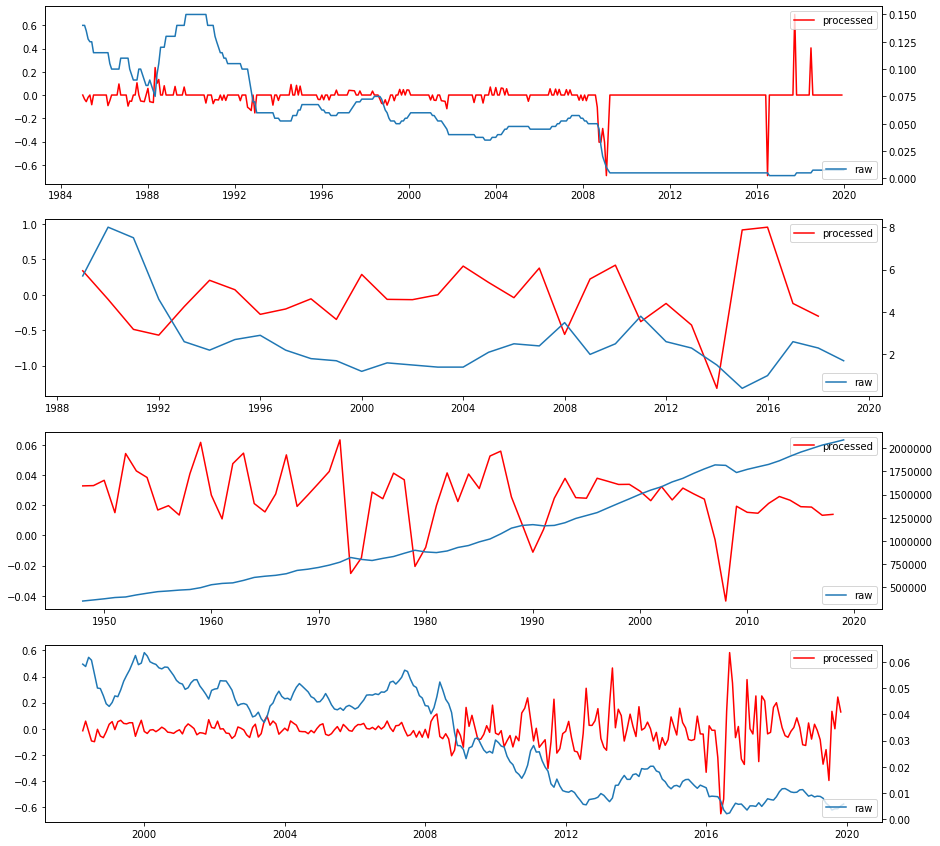

In [0]:
plt.figure(figsize=[15,15])
for i in range(4):
  ax1=plt.subplot(4,1,i+1)
  plt.plot(data_env.data[i].loc[:,'Date'],data_env.data[i].loc[:,'Log-return'],label='processed',color='r')
  plt.legend(loc='upper right')

  ax2 = ax1.twinx() 
  plt.plot(data_env.raw_data[i].Date,data_env.raw_data[i].Value,label='raw')
  plt.legend(loc='lower right')

In [0]:
#raw data
data_env.raw_data[0].head()

,Date,Value
0,1985-01-01,0.1400
1,1985-02-01,0.1400
2,1985-03-01,0.1350
3,1985-04-01,0.1275
4,1985-05-01,0.1250


In [0]:
#processed log-return data
data_env.data[0].head()

,Date,Log-return
0,1985-01-01,0.000000
1,1985-02-01,-0.036368
2,1985-03-01,-0.057158
3,1985-04-01,-0.019803
4,1985-05-01,0.000000


In [0]:
#resample all data into Monthly, combines all the datasets and downloads them
data_env.resample_download_all(frequency='M')

In [0]:
#consolidating our data, in this case with yield and inflation data
df=pd.merge(data_env.data[1],data_env.data[2],on='Date',how='outer')
df=df.dropna()
df.head()

,Date,Log-return_x,Log-return_y
0,1989-01-01,0.338975,0.007311
1,1990-01-01,-0.064539,-0.011093
2,1991-01-01,-0.488847,0.004003
3,1992-01-01,-0.570545,0.024593
4,1993-01-01,-0.167054,0.037739


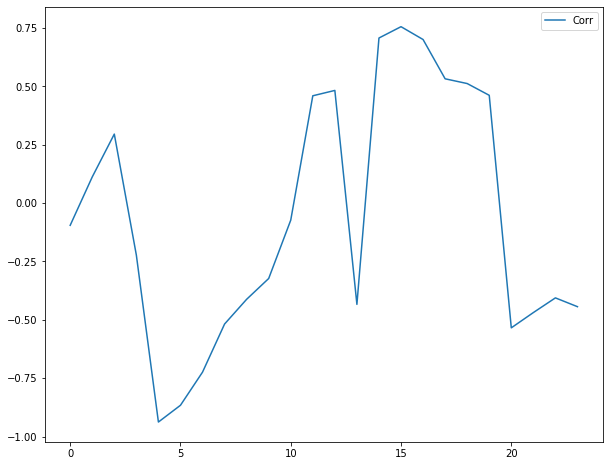

In [0]:
#plotting rolling correlations of 6 months
corr_data=roll_corr(df.loc[:,'Log-return_x'].values,df.loc[:,'Log-return_y'].values,6)
plt.figure(figsize=[10,8])
plt.plot(corr_data,label="Corr")
plt.legend()
plt.show()

In [0]:
#run rolling correlation windows, from length 4 to 20,(1 year is 200)
#from the correlation data calculated, obtain first 4 central moments
from scipy.stats import skew
from scipy.stats import kurtosis
corr_data=pd.DataFrame(columns=['window_length','mean','var','skew','kurtosis'])
for i in range(4,20):
  values=roll_corr(df.loc[:,'Log-return_x'].values,df.loc[:,'Log-return_y'].values,i)
  entry_dict={'window_length':i,
              'mean':np.mean(values),
              'var':np.var(values),
              'skew':skew(values),
              'kurtosis':kurtosis(values)}
  corr_data=corr_data.append(entry_dict,ignore_index=True)
  print(i)

In [0]:
plt.figure(figsize=[10,8])
plt.plot(corr_data.loc[:,'mean'],label='mean')
plt.plot(corr_data.loc[:,'var'],label='variance')
plt.legend()
plt.show()

In [0]:
plt.figure(figsize=[10,8])
plt.plot(corr_data.loc[:,'skew'],label='skew')
plt.plot(corr_data.loc[:,'kurtosis'],label='kurtosis')
plt.legend()
plt.show()